In [1]:
# !pip install netCDF4
# !pip install cartopy
# !pip install basemap 
# import sys
# print(sys.executable)
# print(sys.version)
# print(sys.version_info)

In [1]:
import netCDF4 as nc
import os
import numpy as np

PATH = os.path.join('..', 'Data', 'CHIRPS2')

def read_data(file_path):
    data = nc.Dataset(file_path)
    return data

ds = read_data(os.path.join(PATH, 'chirps-v2.0.monthly.nc'))

time_var = ds.variables["time"][:]

In [4]:
time_var

masked_array(data=[  366.,   397.,   425.,   456.,   486.,   517.,   547.,
                     578.,   609.,   639.,   670.,   700.,   731.,   762.,
                     790.,   821.,   851.,   882.,   912.,   943.,   974.,
                    1004.,  1035.,  1065.,  1096.,  1127.,  1155.,  1186.,
                    1216.,  1247.,  1277.,  1308.,  1339.,  1369.,  1400.,
                    1430.,  1461.,  1492.,  1521.,  1552.,  1582.,  1613.,
                    1643.,  1674.,  1705.,  1735.,  1766.,  1796.,  1827.,
                    1858.,  1886.,  1917.,  1947.,  1978.,  2008.,  2039.,
                    2070.,  2100.,  2131.,  2161.,  2192.,  2223.,  2251.,
                    2282.,  2312.,  2343.,  2373.,  2404.,  2435.,  2465.,
                    2496.,  2526.,  2557.,  2588.,  2616.,  2647.,  2677.,
                    2708.,  2738.,  2769.,  2800.,  2830.,  2861.,  2891.,
                    2922.,  2953.,  2982.,  3013.,  3043.,  3074.,  3104.,
                    3135.

In [2]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import interpolate
import scipy
import tqdm
import matplotlib.colors as mcolors
from helpers import process_h as helper
from helpers import visualize_h as vis_helper



In [3]:
data_relative_path = os.path.join('..', 'Data')
precipitation_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
WTIO_path = os.path.join(data_relative_path,'CMIP6','WTIO')
SEIO_path = os.path.join(data_relative_path,'CMIP6','SEIO')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')

# Initial data Analysis and Presentation
We will start by displaying the average precipitation in the Middle East region for the month of October, for each model and for CHIRPS2 (which is "Rainfall Estimates from Rain Gauge and Satellite Observations"). This should give as a good understanding of which models are performing well in this region and which ones are not.    
An important concern we ran into was the scale - each model uses a different scale, and so since we want to compare them all together (and specifically to the CHIRPS2 dataset), we need to interpolate the data to a common scale, which we chose to be the CHIRPS2 scale.    
Another important step - we needed to convert the precipitation units of the models from `kg m-2 s-1` to `mm/month`. To do so, we multiply the precipitation values by the number of seconds in a day (86400) and the number of days in a month (31). Along the way we multiply and divide by 1000 to convert the units from kg to g and then to mm, but it cancels out.    
One last detail is the boundaries of the map we want to plot. We will use 25N-40N and 25E-50E, in accordance with the article we are basing our analysis on.

In [4]:
unit_conversion = 86400 * 31
bounds_lat = [20, 40]
bounds_lon = [20, 50]
boundaries = bounds_lon + bounds_lat

In [5]:
chirps_data = nc.Dataset(f"{CHIRPS_path}/chirps_octobers_middle_east_1981_2010.nc")
chirps_precip_data = chirps_data['precip'][:]
chirps_precip_mean = np.mean(chirps_precip_data, axis=0)

In [6]:
chirps_dim = chirps_data['precip'].shape[1], chirps_data['precip'].shape[2]

An issue we ran into here is how to choose the correct interpolation method. We are not sure if there are standards for weather related interpolation methods, and so we plan on looking into it.

In [7]:
interpolated_matrices = helper.collect_all_datasets(precipitation_path, chirps_dim, unit_conversion, bounds_lat, bounds_lon)

  8%|██████▉                                                                            | 2/24 [00:00<00:02, 10.76it/s]

pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc


 17%|█████████████▊                                                                     | 4/24 [00:00<00:01, 10.20it/s]

pr_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
pr_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19811016-20101016_v20191021.nc
pr_Amon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190913.nc


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01, 10.24it/s]

pr_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19811016-20101016_v20200624.nc
pr_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_19811016-20101016_v20190927.nc
pr_Amon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191209.nc


 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:01, 10.45it/s]

pr_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19811016-20101016_v20190726.nc
pr_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
pr_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:00, 11.08it/s]

pr_Amon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20191226.nc
pr_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19811016-20101016_v20180803.nc


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00, 11.58it/s]

pr_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_19811017-20101017_v20191017.nc
pr_Amon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
pr_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:01<00:00, 11.18it/s]

pr_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19811016-20101016_v20190222.nc
pr_Amon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190630.nc


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:02<00:00, 10.45it/s]

pr_Amon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
pr_Amon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.33it/s]

pr_Amon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200623.nc
pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190406.nc


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.53it/s]


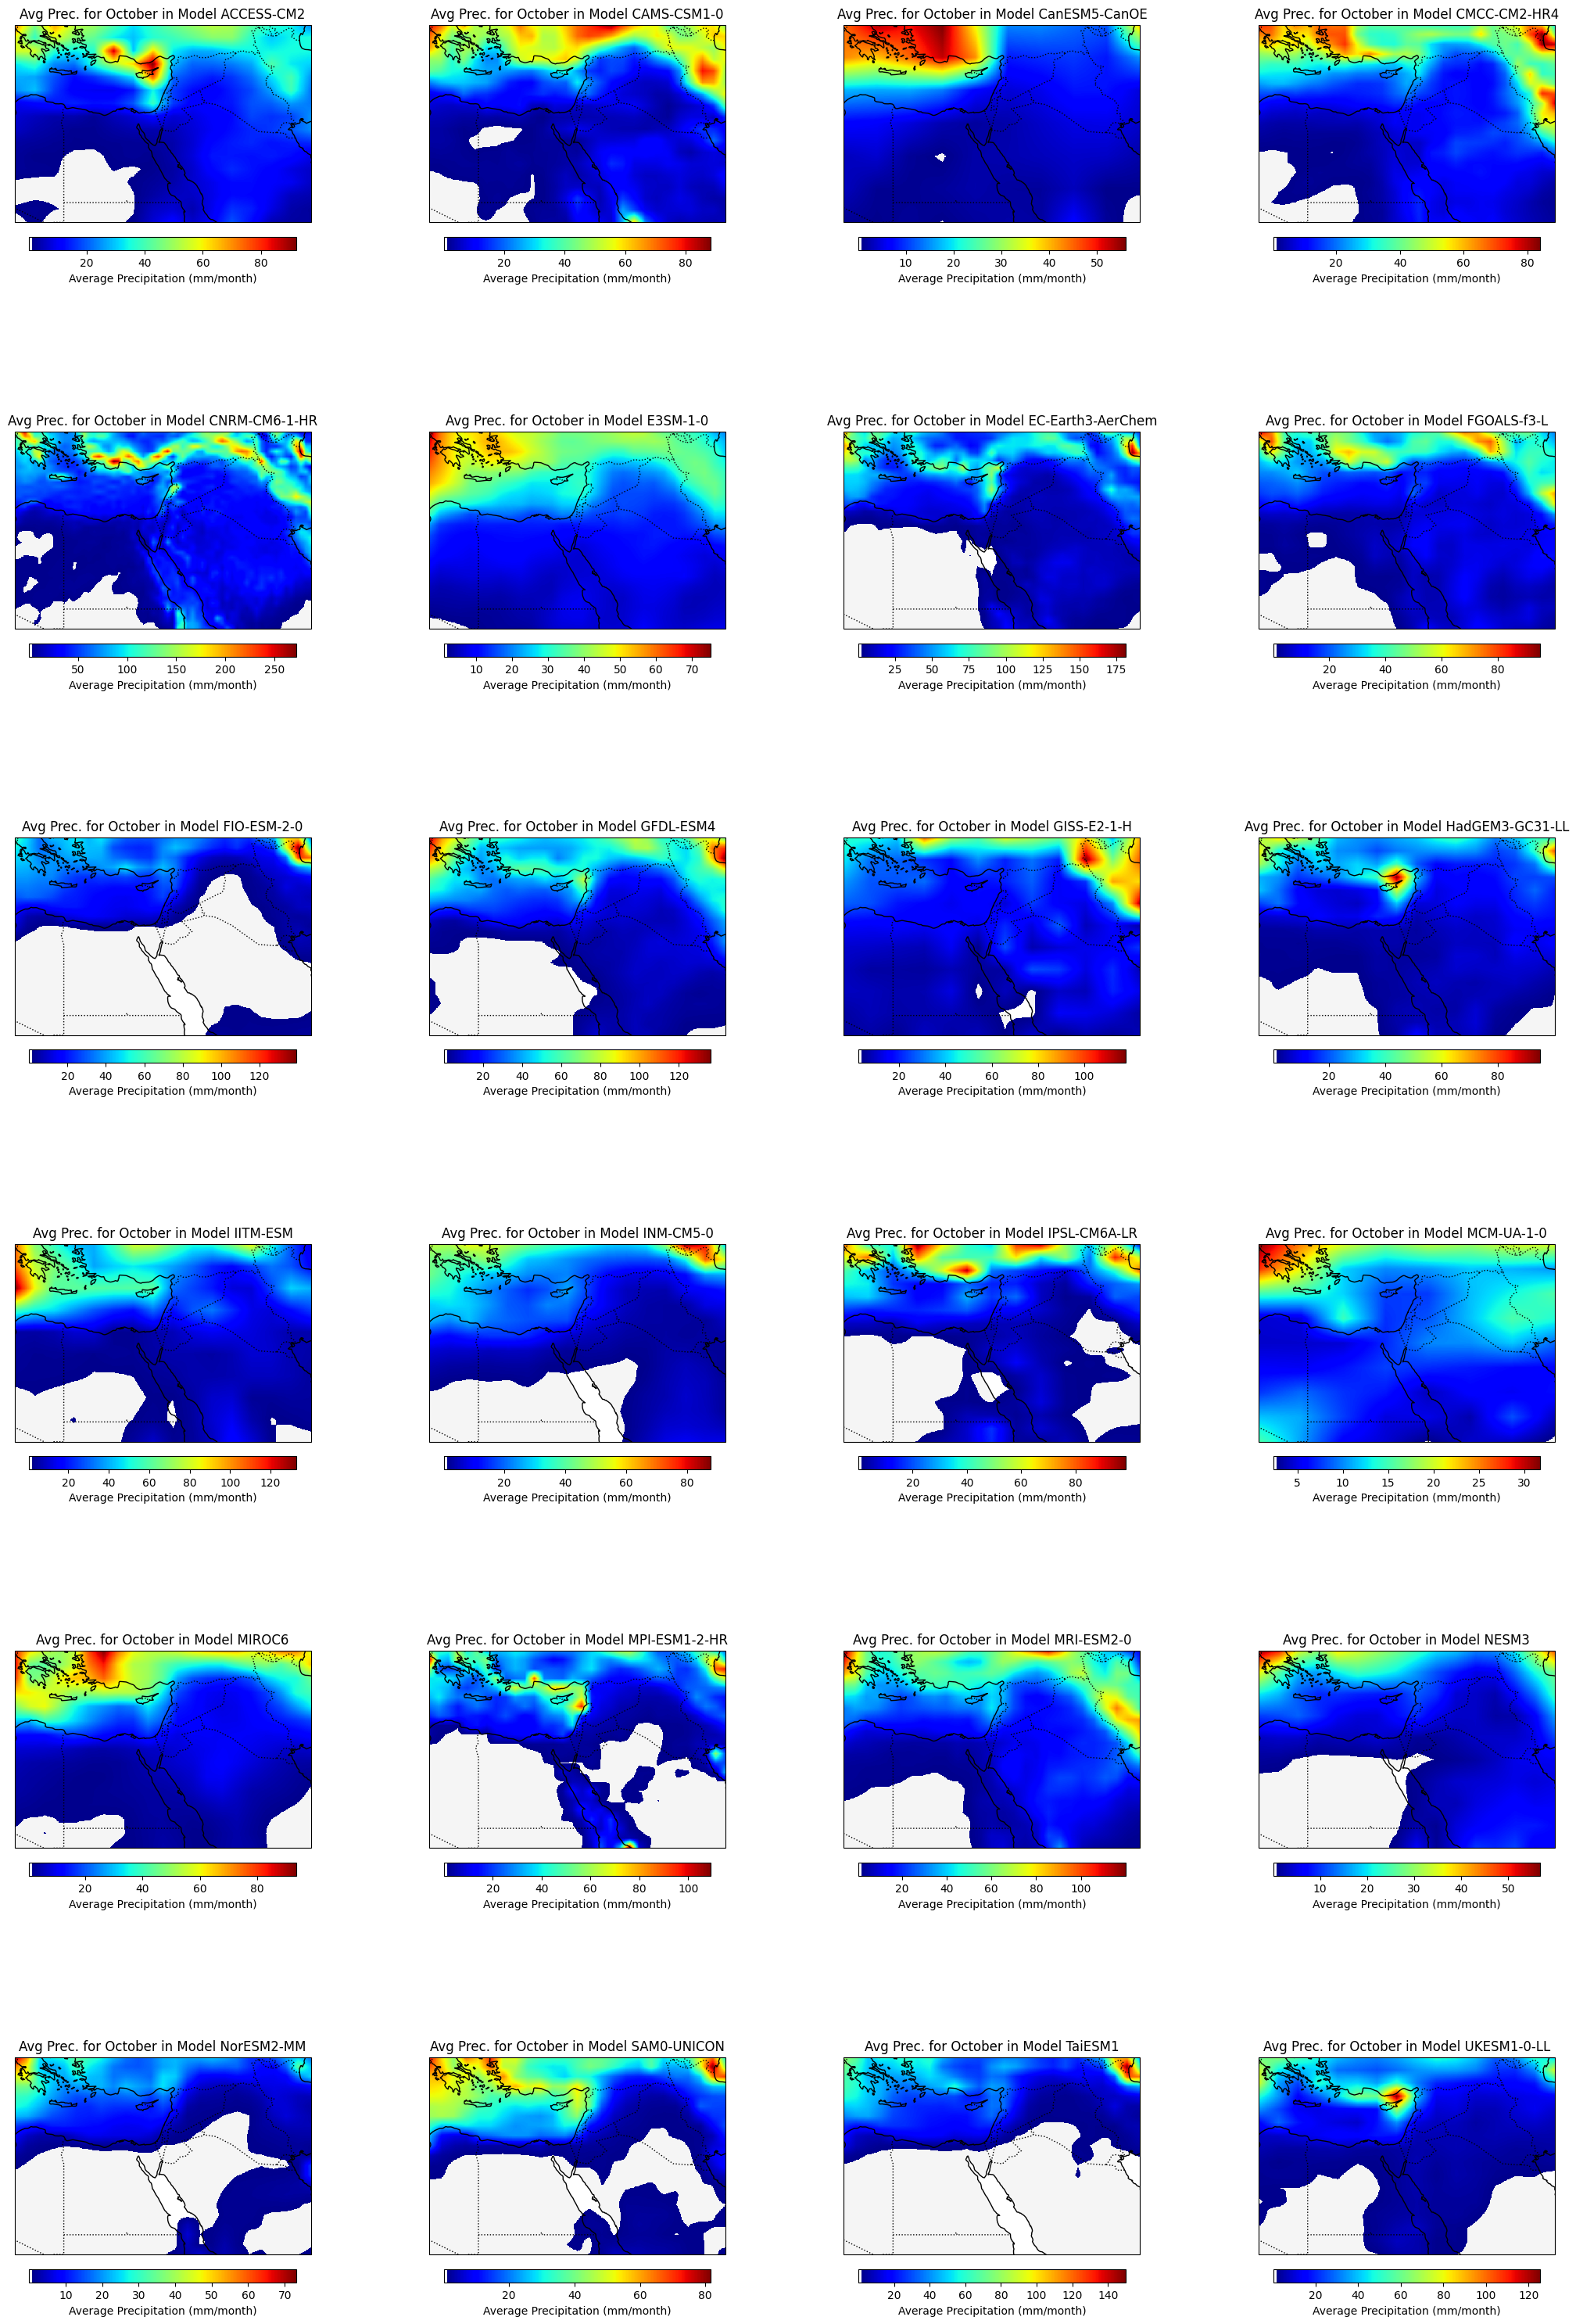

In [8]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats = list(interpolated_matrices.values())
titles = list(interpolated_matrices.keys())


for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    vis_helper.plot_precp_heatmap(ax, value, boundaries, 'Average Precipitation (mm/month)', f'Avg Prec. for October in Model {key.split("_")[2]}', 0.01)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [9]:
interpolated_matrix_array_mean = np.mean(np.array([arr for arr in interpolated_matrices.values()]),axis=0)


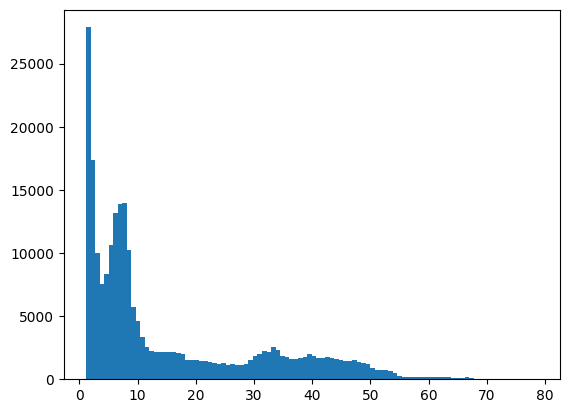

In [10]:
ax = plt.hist(interpolated_matrix_array_mean.ravel(),bins=100)
plt.show()

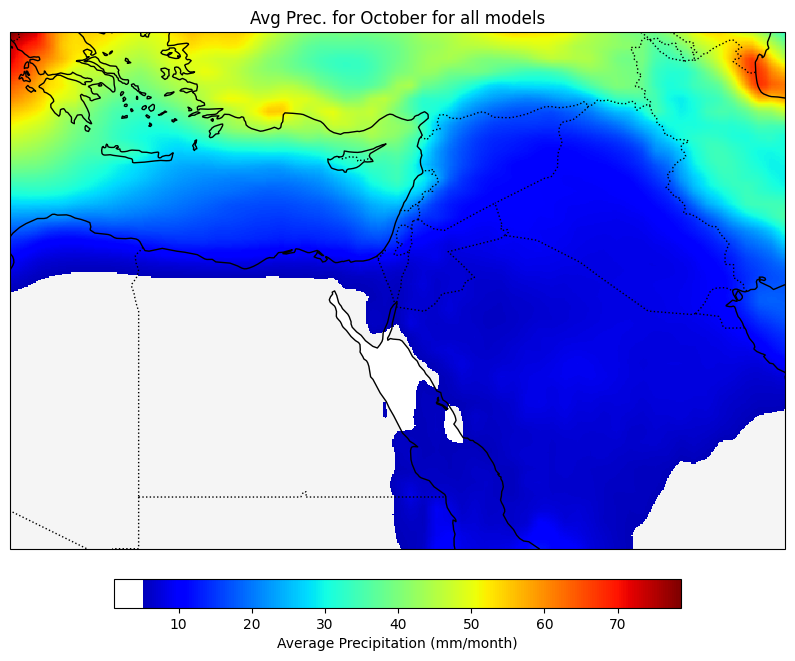

In [11]:
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

vis_helper.plot_precp_heatmap(ax2, interpolated_matrix_array_mean, boundaries, 'Average Precipitation (mm/month)', 'Avg Prec. for October for all models')

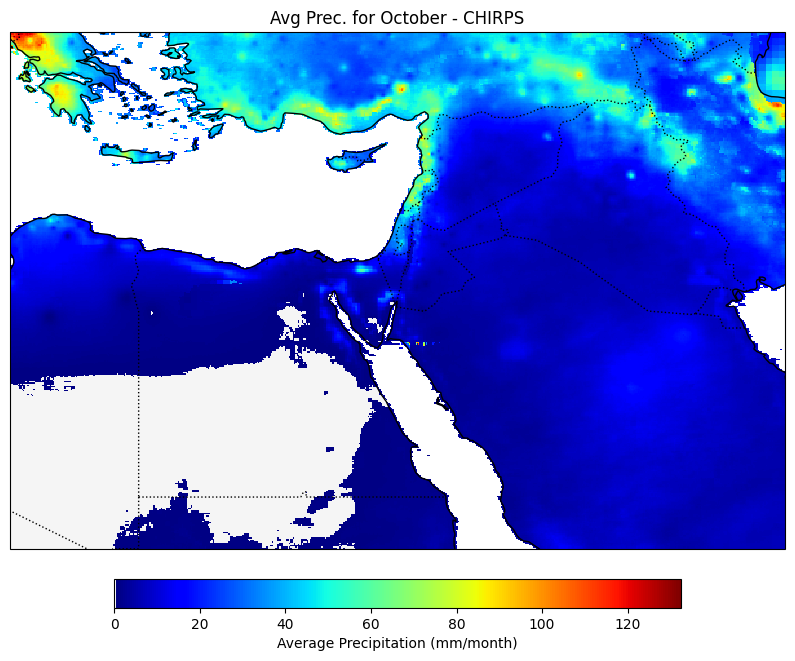

In [12]:
fig3, ax2 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_precp_heatmap(ax2, chirps_precip_mean, boundaries, 'Average Precipitation (mm/month)', 'Avg Prec. for October - CHIRPS', 0)

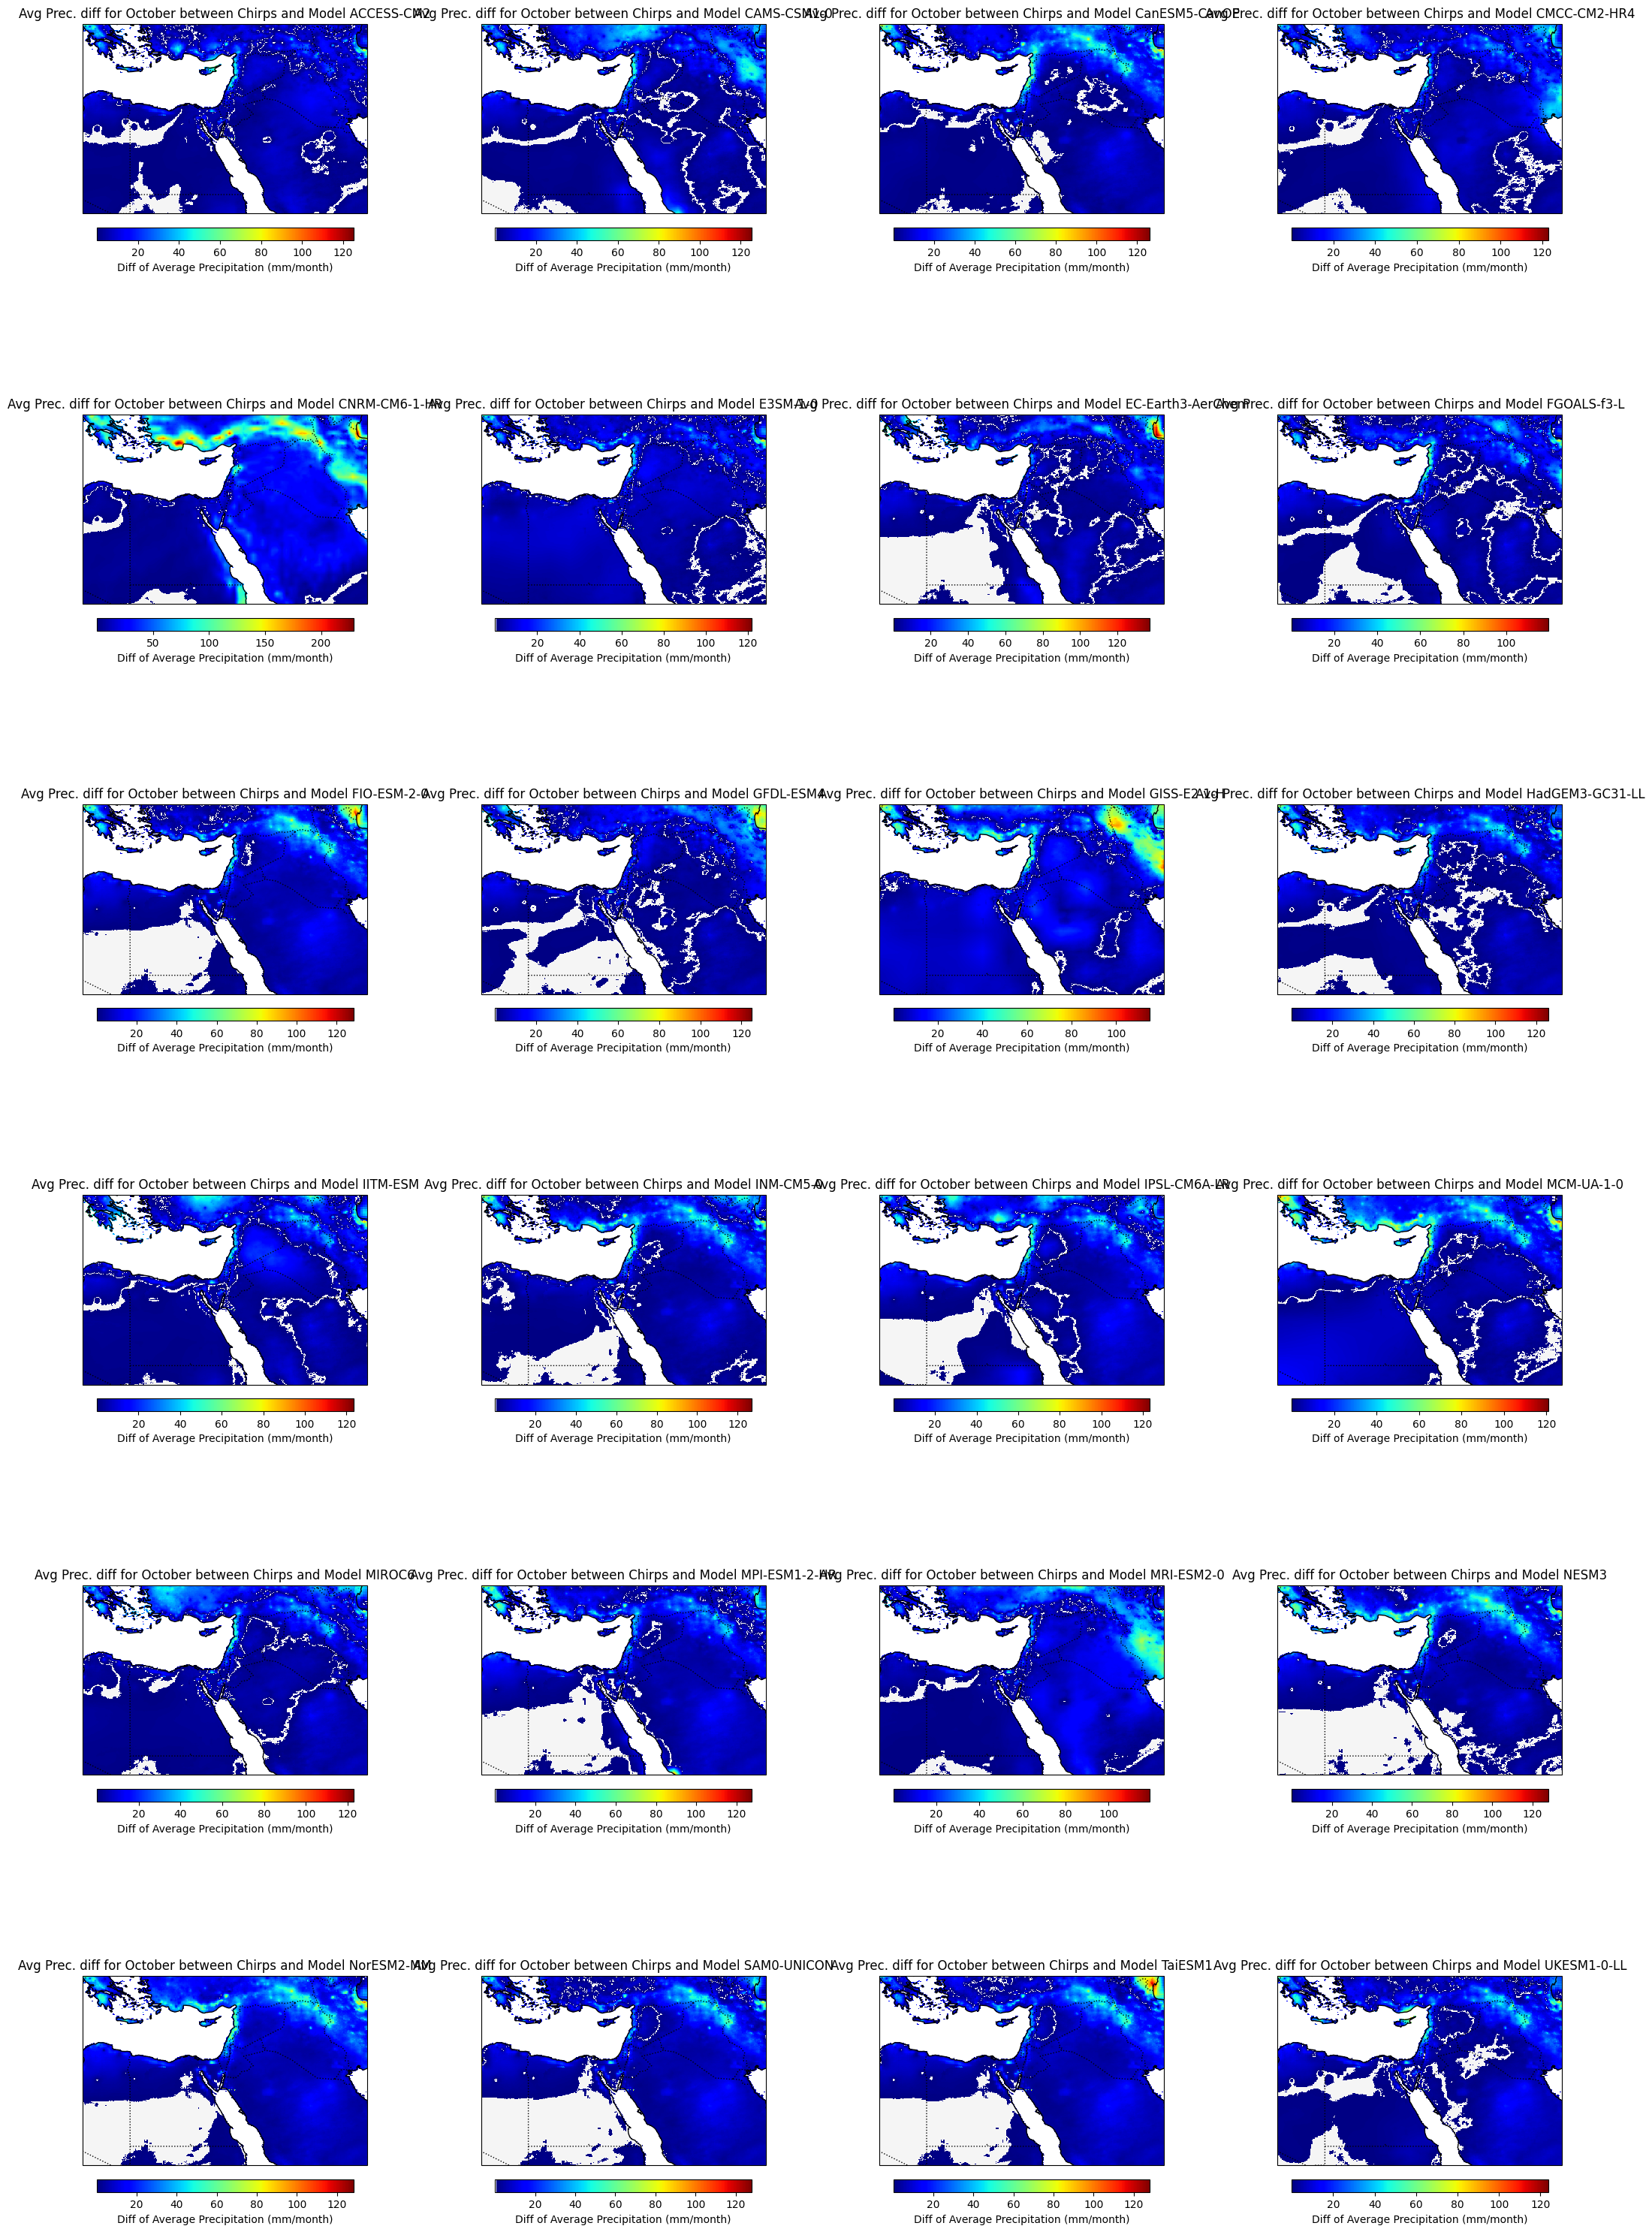

In [13]:
fig4, axes4 = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig4.tight_layout()
mats = [np.abs(chirps_precip_mean - arr) for arr in list(interpolated_matrices.values())]
titles = list(interpolated_matrices.keys())

for i, (ax, key, value) in enumerate(zip(axes4.ravel(), titles, mats)):
    vis_helper.plot_precp_heatmap(ax, value, boundaries, 'Diff of Average Precipitation (mm/month)', f'Avg Prec. diff for October between Chirps and Model {key.split("_")[2]}', 0)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

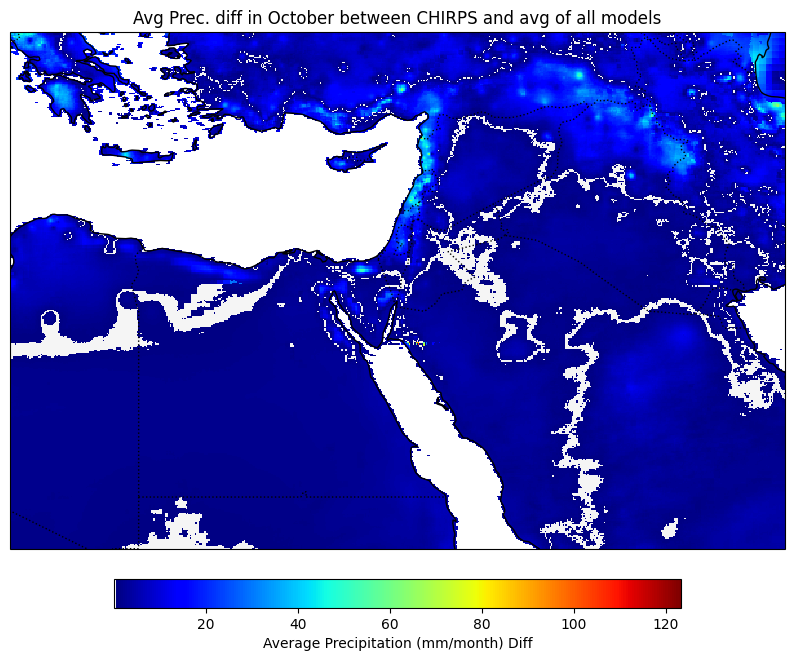

In [14]:
fig5, ax5 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_precp_heatmap(ax5, np.abs(chirps_precip_mean - interpolated_matrix_array_mean), boundaries, 'Average Precipitation (mm/month) Diff', 'Avg Prec. diff in October between CHIRPS and avg of all models', 0)

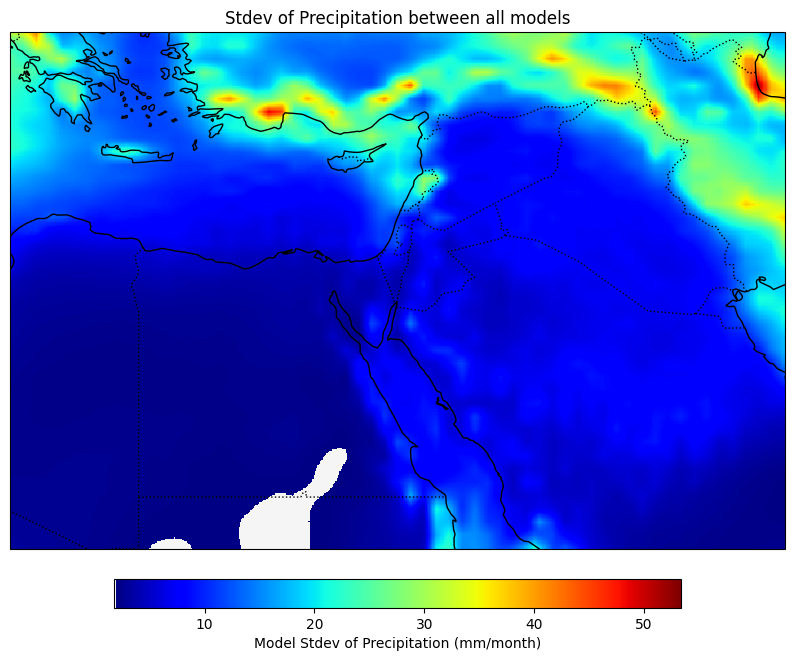

In [15]:
interpulated_matrix_array_std = np.std(np.array([arr for arr in interpolated_matrices.values()]),axis=0)
fig6, ax6 = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_precp_heatmap(ax6, interpulated_matrix_array_std, boundaries, 'Model Stdev of Precipitation (mm/month)', 'Stdev of Precipitation between all models', 0)